In [2]:
import scipy.stats as st
from scipy import integrate
import numpy as np
import matplotlib.pyplot as plt
import torch
from lifelines import KaplanMeierFitter  
import seaborn as sns
import numpy as np
from scipy.optimize import least_squares
def g1(x):
    g = x[:,0] + 2*x[:,1] + 3*x[:,2] + 4*x[:,3] + 5*x[:,4] -15.5
    return g
def g2(x):
    g = (x[:,0]**2 + 2*x[:,1]**2 + x[:,2]**3 + torch.sqrt(x[:,3]+1) + torch.log(x[:,4]+1) -8.6)*2+1.13
    return g
def g3(x):
    y1 = x[:,0]**2*x[:,1]**3 -2* torch.log(x[:,2]+1) + torch.sqrt(x[:,3]*x[:,4]+1) - torch.exp(x[:,4]/2) -8.2
    y2 = (x[:,0]+2*x[:,1]-x[:,2]-0.5*x[:,3]+x[:,4])
    y3 = (x[:,0]-3*x[:,1]-2*x[:,2]+1.5*x[:,3]+x[:,4])
    g = (y1-y2+1.5*y3)*(y1+2*y2-0.5*y3)/20-3.05/2
    return g
def g4(x):
    g = (x[:,0]**2*x[:,1]**3 + torch.log(x[:,2]+1) + torch.sqrt(x[:,3]*x[:,4]+1) + torch.exp(x[:,4]/2))**2/20 -6.0
    return g
def inv_func1(beta11,beta12 , g, u, z, x,p):
    '''
    beta: 线性协变量系数
    g:非线性协变量函数
    u:均匀分布随机变量
    z:线性部分协变量
    x:非线性部分协变量
    p:主要事件生成概率
    '''
    hazard = torch.exp(beta11*z[:,0]+beta12*z[:,1]  + g(x))
    y = -torch.log(1-(1-(1-u)**(1/(hazard)))/p)
    return y
#定义主要事件逆概率函数

def inv_func2(beta21,beta22,z,u):
    '''
    beta: 线性协变量系数
    u:均匀分布随机变量
    z:线性部分协变量
    '''
    hazard = torch.exp(beta21*z[:,0]+beta22*z[:,1])
    rate = torch.exp(hazard)
    y = -torch.log(1-u)/rate
    return y
#定义竞争风险事件的逆概率函数
def inv_funcc(a,b,u):
    c=u*(b-a)+a
    return c

def dataproduce(n, beta11, beta12, beta21, beta22, g_index, z_index, seed, p, a, b):
    '''
    n:样本量
    beta:线性协变量系数
    g_index:非线性协变量函数的选择指标
    z_index:线性协变量分布的选择指标
    seed:随机数种子
    mu:删失随机变量参数
    p:生成主要事件概率
    '''
    np.random.seed(seed)
    torch.manual_seed(seed)#设置随机数种子
    sigma = 0.5*torch.ones((5,5)) + 0.5*torch.eye(5)
    mvnorm = st.multivariate_normal(mean=[0,0,0,0,0], cov=sigma)#定义Gaussian copula
    X = torch.from_numpy(2*st.norm.cdf(mvnorm.rvs(n)))
    if z_index==1:
        Z = torch.randint(2,size = [2*n])
    else:
        Z = torch.randn(2*n)/torch.sqrt(torch.tensor([2.0]))+0.5#生成线性协变量
    Z = Z.reshape(n,2)
    if g_index==1:
        g = g1
    if g_index==2:
        g = g2
    if g_index==3:
        g = g3
    if g_index==4:
        g = g4
    #选择函数g
    u =  torch.rand(n)
    t = inv_func1(beta11, beta12, g, u, Z, X,p).double()#生成事件发生时间
    index2=~(t>0)
    n2=int(sum(index2))
    #确定竞争风险事件的指标集和样本量
    u=torch.rand(n2)
    t2=inv_func2(beta21,beta22,Z[index2],u).double()
    #生成竞争风险事件的数据
    t[index2]=t2
    epsilon = torch.zeros(n)
    epsilon[index2] = 1
    epsilon = epsilon+1
    #得出事件类型指标
    u = torch.rand(n)
    C = inv_funcc(a,b,u)
    delta = (C >= t)+0.0
    t = torch.minimum(t,C)
    return t.reshape(n,1),epsilon.reshape(n,1),Z.reshape(n,2),X,delta.reshape(n,1)
def Uniform_function(x,a,b):
    y = (x+a)/(a+b)
    condition = np.logical_and(x > -a, x < b)
    condition1 = np.logical_and(x >= b,x>=b)
    y = y * condition.astype(int)+1*condition1.astype(int)
    return y
def objective(params, x, y):
    a, b = params
    return np.abs(y - (a + x) / (a + b))

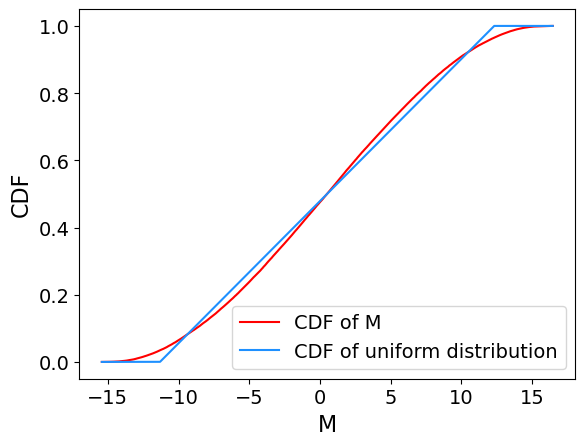

In [7]:
import numpy as np
import matplotlib.pyplot as plt

n = 100000
seed = 0
z_index = 1
np.random.seed(seed)
torch.manual_seed(seed)  # 设置随机数种子
sigma = 0.5 * torch.ones((5, 5)) + 0.5 * torch.eye(5)
mvnorm = st.multivariate_normal(mean=[0, 0, 0, 0, 0], cov=sigma)  # 定义Gaussian copula
X = torch.from_numpy(2 * st.norm.cdf(mvnorm.rvs(n)))
if z_index == 1:
    Z = torch.randint(2, size=[2 * n])
else:
    Z = torch.randn(2 * n) / torch.sqrt(torch.tensor([2.0])) + 0.5  # 生成线性协变量
Z = Z.reshape(n, 2)
M = g1(X) + Z[:, 0] + Z[:, 1]
x = M.sort().values.detach().numpy()
y = np.arange(1, len(x) + 1) / len(x)
# 初始参数值
initial_params = np.array([1.0, 1.0])

# 使用最小二乘法拟合数据
result = least_squares(objective, initial_params, args=(x, y))

# 提取最优参数值
a_optimal, b_optimal = result.x

plt.plot(x, y, label='CDF of M', color='red')
plt.plot(x, Uniform_function(x, a_optimal, b_optimal), label='CDF of uniform distribution', color='dodgerblue')

plt.ylabel('CDF',fontsize=16)
plt.xlabel('M',fontsize=16)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(loc='lower right',fontsize=14)
plt.savefig('1.1.png', dpi=1000)

plt.show()

In [3]:
n =100000
seed = 0
z_index =1
np.random.seed(seed)
torch.manual_seed(seed)#设置随机数种子
sigma = 0.5*torch.ones((5,5)) + 0.5*torch.eye(5)
mvnorm = st.multivariate_normal(mean=[0,0,0,0,0], cov=sigma)#定义Gaussian copula
X = torch.from_numpy(2*st.norm.cdf(mvnorm.rvs(n)))
if z_index==1:
    Z = torch.randint(2,size = [2*n])
else:
    Z = torch.randn(2*n)/torch.sqrt(torch.tensor([2.0]))+0.5#生成线性协变量
Z = Z.reshape(n,2)
M = g2(X)+Z[:,0]+Z[:,1]
x = M.sort().values.detach().numpy()
y = np.arange(1, len(x) + 1) / len(x)
# 初始参数值
initial_params = np.array([1.0, 1.0])

# 使用最小二乘法拟合数据
result = least_squares(objective, initial_params, args=(x, y))

# 提取最优参数值
a_optimal, b_optimal = result.x


<Figure size 19200x14400 with 0 Axes>

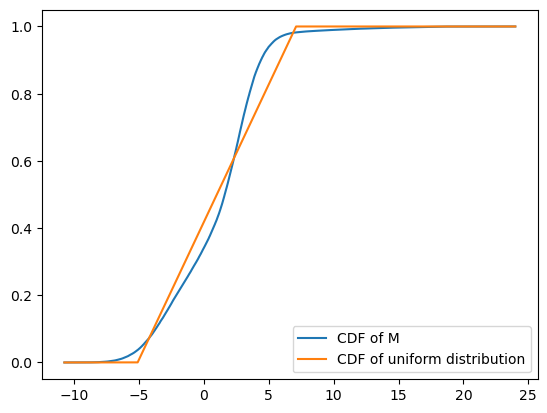

<Figure size 19200x14400 with 0 Axes>

In [4]:
n =100000
seed = 0
z_index =1
np.random.seed(seed)
torch.manual_seed(seed)#设置随机数种子
sigma = 0.5*torch.ones((5,5)) + 0.5*torch.eye(5)
mvnorm = st.multivariate_normal(mean=[0,0,0,0,0], cov=sigma)#定义Gaussian copula
X = torch.from_numpy(2*st.norm.cdf(mvnorm.rvs(n)))
if z_index==1:
    Z = torch.randint(2,size = [2*n])
else:
    Z = torch.randn(2*n)/torch.sqrt(torch.tensor([2.0]))+0.5#生成线性协变量
Z = Z.reshape(n,2)
M = g3(X)+Z[:,0]+Z[:,1]
x = M.sort().values.detach().numpy()
y = np.arange(1, len(x) + 1) / len(x)
# 初始参数值
initial_params = np.array([1.0, 1.0])

# 使用最小二乘法拟合数据
result = least_squares(objective, initial_params, args=(x, y))

# 提取最优参数值
a_optimal, b_optimal = result.x
plt.plot(x,y,label='CDF of M')
plt.plot(x,Uniform_function(x,a_optimal,b_optimal),label = 'CDF of uniform distribution')
plt.legend()
plt.figure(dpi=3000)

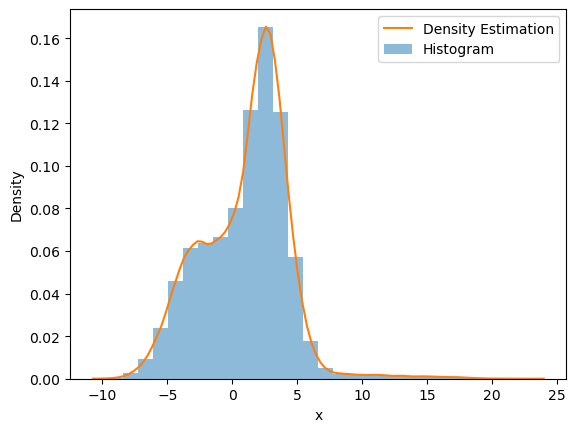

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

# 生成一组随机样本（示例数据）
np.random.seed(0)
sample_data = x

# 使用核密度估计估计密度函数
kde = gaussian_kde(sample_data)

# 生成一组用于绘制密度函数的x值
x = np.linspace(min(sample_data), max(sample_data), 100)

# 计算估计的密度函数值
density_estimation = kde(x)

# 绘制原始样本数据的直方图
plt.hist(sample_data, bins=30, density=True, alpha=0.5, label='Histogram')

# 绘制估计的密度函数曲线
plt.plot(x, density_estimation, label='Density Estimation')

plt.xlabel('x')
plt.ylabel('Density')
plt.legend()
plt.show()